## Tensorflow-Lite with MNIST. Post Quantization Training
Post-training quantization is a conversion technique that can reduce model size while also improving CPU and hardware accelerator latency, with little degradation in model accuracy. You can quantize an already-trained float TensorFlow model when you convert it to TensorFlow Lite

### Importing Basic Libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sys import getsizeof

In [2]:
'''The h5py package is a Pythonic interface to the HDF5 binary data format. 
It lets you store huge amounts of numerical data, and easily manipulate 
that data from NumPy. For example, you can slice into multi-terabyte datasets 
stored on disk, as if they were real NumPy arrays.'''
import tensorflow as tf
import h5py
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model, model_to_dot

In [3]:
print(tf.__version__)

2.5.0


### Getting the file size and converting it to bytes


In [4]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [5]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size/1024, 3)) + 'Kilobytes')
    elif unit == 'MB':
        return print('File Size: ' + str(round(size/(1024*1024), 3)) + 'Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

### We are using Fashion MNIST Dataset

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_lables) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [8]:
train_images.shape

(60000, 28, 28)

In [9]:
len(train_images)

60000

In [10]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [11]:
test_images.shape

(10000, 28, 28)

In [12]:
len(test_images)

10000

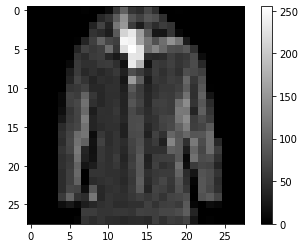

In [13]:
#preprocessing
plt.figure()
plt.imshow(train_images[19], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [14]:
#Normalising the images
train_images = train_images/255.0
test_images = test_images/255.0

In [15]:
#building the model
model = keras.Sequential([
  Flatten(input_shape=(28,28)),
  Dense(128, activation='relu'),
  Dense(10)                 
])

In [16]:
#Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. 
#Adam combines the best properties of the AdaGrad and RMSProp algorithms 
#to provide an optimization algorithm that can handle sparse gradients on noisy problems.
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

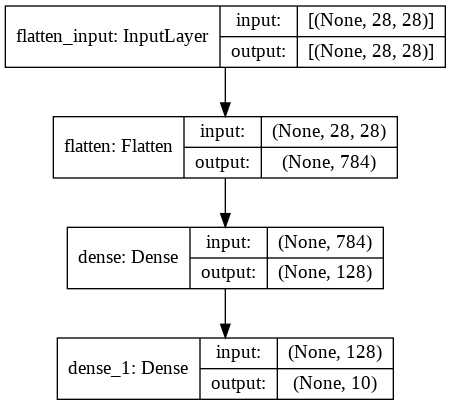

In [18]:
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [20]:
#training the model
h = model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.4994 - accuracy: 0.8250
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3747 - accuracy: 0.8661
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3373 - accuracy: 0.8769
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3117 - accuracy: 0.8863
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2958 - accuracy: 0.8913
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2808 - accuracy: 0.8965
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2719 - accuracy: 0.8984
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2589 - accuracy: 0.9037
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2487 - accuracy: 0.9074
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.240

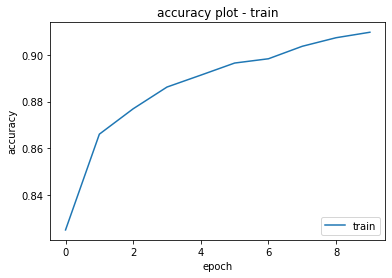

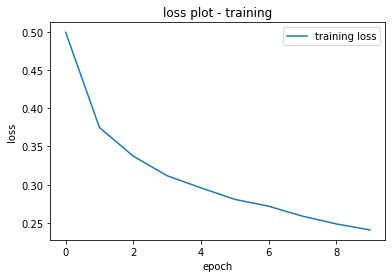

In [21]:
plt.plot(h.history['accuracy'])
plt.legend(['train'], loc='lower right')
plt.title('accuracy plot - train')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.legend(['training loss'], loc = 'upper right')
plt.title('loss plot - training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [23]:
#Saving the Keras Model
KERAS_MODEL_NAME='tf_MODEL_FASHION_MNIST.h5'
model.save(KERAS_MODEL_NAME)

In [31]:
#checking the file size
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File Size: 1.19Megabytes


In [25]:
#evaluating our model
test_loss, test_acc = model.evaluate(test_images, test_lables, verbose=2)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

313/313 - 0s - loss: 0.3454 - accuracy: 0.8790
Test Accuracy: 0.8790000081062317
Test Loss: 0.3453993499279022


### Converting Keras model to tflite

In [26]:
#Saving the tflite model
TF_LITE_MODEL_FILE_NAME = 'tf_lite_model.tflite'

In [27]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpybzwcz5o/assets


In [28]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

408544

In [29]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File Size: 398.969Kilobytes


In [32]:
#Check input tensor shape
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


In [33]:
#resizing tensor shapes
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [34]:
test_images.dtype

dtype('float64')

In [35]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [36]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [37]:
#Testing the TF-Lite Model
acc = accuracy_score(prediction_classes, test_lables)

In [38]:
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.879


### Post training quantization of TF Lite Model

In [39]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [40]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE] #Optimise for Space
# tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tf_lite_converter.target_spec.supported_types = [tf.float16] #Quantised to float16
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpswnz7i9x/assets


INFO:tensorflow:Assets written to: /tmp/tmpswnz7i9x/assets


In [41]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

103856

In [42]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File Size: 101.422Kilobytes


In [44]:
#Check input tensor shape
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


In [45]:
#Resize Input Tensor Shape 
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [46]:
test_images.dtype

dtype('float64')

In [47]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [48]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [49]:
acc = accuracy_score(prediction_classes, test_lables)

In [50]:
print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.8786
